# Bayesian Gaussian Mixture Model in Pyro

Trying to figure it out for myself without using autoguide.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=True)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.nn import Parameter
from torch.distributions import constraints
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

### Generate Data for a GMM

* Specify the number of clusters `N_clusters` and the dimensionality of the data points `dims`

* Randomly initialize the means and coviariance matrices

* Sample a radndom number of points from each class from  N(mean=200,var=50)

* Randomly shuffle the data (for good measure, probably doesnt actually matter here)

In [116]:
N_classes = 7
dims = 2

true_means = 10*torch.randn((N_classes,dims))
covs = torch.diag_embed(3*torch.ones(N_classes,dims)) + torch.randn(N_classes,dims,dims)
covs = torch.bmm(covs,covs.permute(0,2,1)) #ensure SPD-ness
N_points_per_class = (200 + 80*torch.randn(N_classes)).to(torch.int)
inds = torch.cumsum(N_points_per_class,0)
N_points_tot = N_points_per_class.sum()
for i,n in enumerate(N_points_per_class):
    mvn = dist.MultivariateNormal(true_means[i],covariance_matrix=covs[i])
    samps = mvn.sample(torch.Size([n]))
    if i==0:
        data = mvn.sample(torch.Size([n]))
        labels = torch.zeros(torch.Size([n]))
    else:
        data = torch.cat((data,samps))
        labels = torch.cat((labels, i*torch.ones(n)))
order = torch.randperm(N_points_tot)
data = data[order]
labels = labels[order]

Get a flavor of the data you just generated. If you dont like it you can always make more.

In [117]:
def draw_elliptical_contour(mu, sigma):
    mu = mu.numpy()
    evals,evecs = sigma.symeig(eigenvectors=True)
    v = evecs[:,evals.argmax()]
    a = np.arctan2(v[1],v[0])*(180/np.pi)
    d = 2*torch.sqrt(5.991*evals)
    return Ellipse(mu, d[1], d[0], angle=a, fill=False)

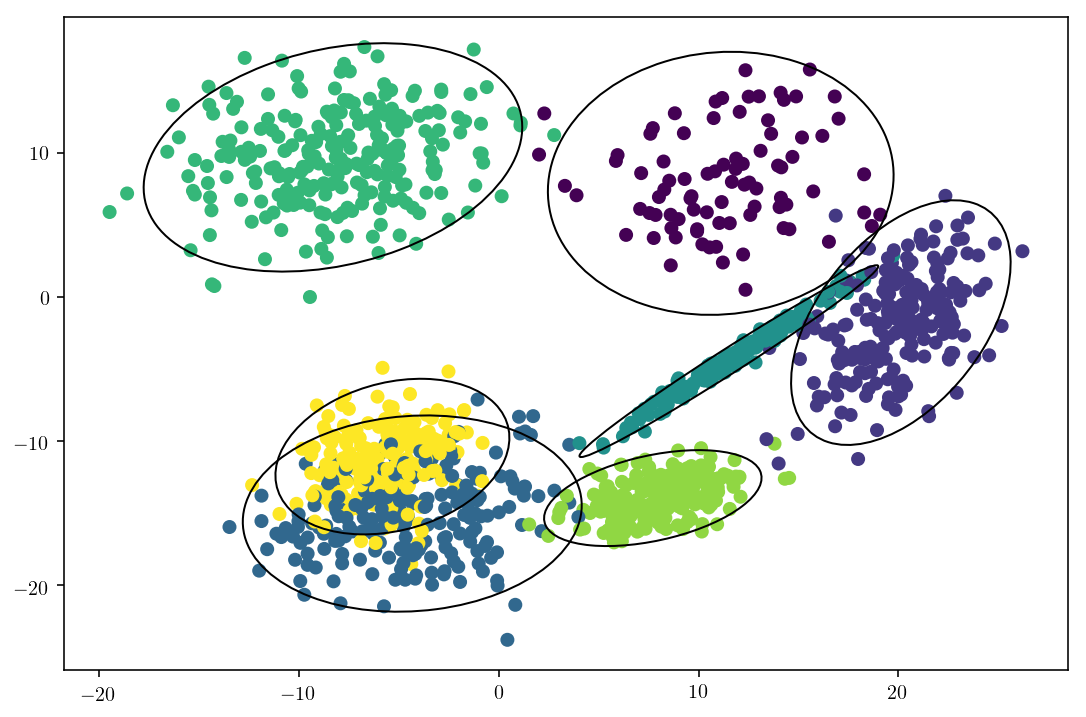

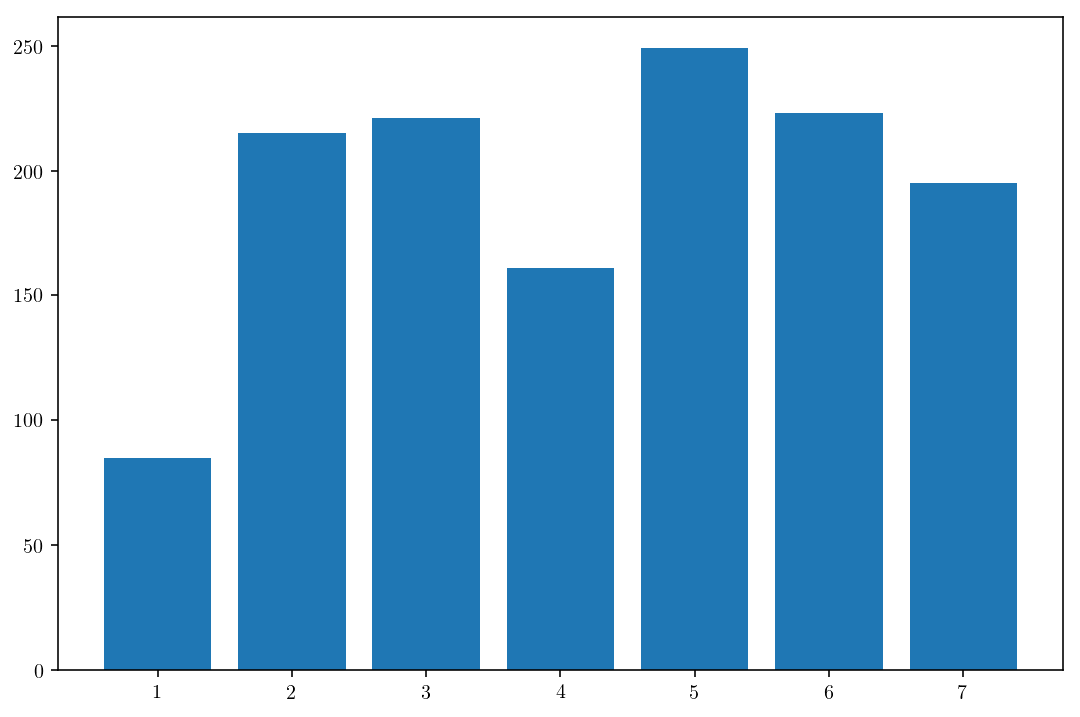

In [118]:
if dims>2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data.numpy()[:,0], data.numpy()[:,1], data.numpy()[:, 2],c = labels.numpy())
    #ax.scatter(true_means[i,0],true_means[i,1],true_means[i,2],marker="*",s=50)
    ax.set_xlabel(r"x")
    ax.set_ylabel(r"y")
    ax.set_zlabel(r"z")
    ax.view_init(30, 50)
    plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data.numpy()[:,0],data.numpy()[:,1],c=labels.numpy())
for i in range(N_classes):
        ax.add_patch(draw_elliptical_contour(true_means[i],covs[i]))
plt.show()

plt.bar(np.arange(N_classes)+1,N_points_per_class.numpy())
plt.show()

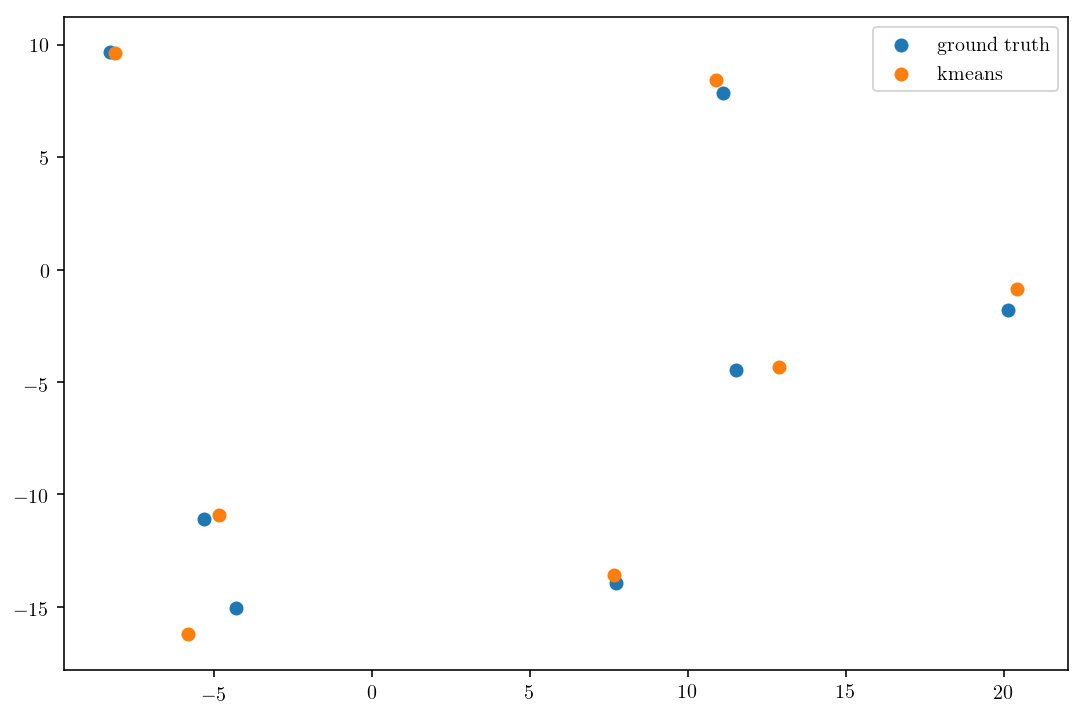

In [119]:
kmeans = KMeans(n_clusters=N_classes,n_jobs=3).fit(data.numpy())
#plt.scatter(learned_means[:,0],learned_means[:,1],label='learned')
plt.scatter(true_means[:,0].numpy(),true_means[:,1].numpy(),label='ground truth')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],label='kmeans')
plt.legend()
plt.show()

### Now lets use pyro to infer the parameters of the mixtures

In [125]:
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro import poutine
import warnings
from pyro import poutine

In [126]:
warnings.filterwarnings("ignore")

In [127]:
pyro.enable_validation(True)

In [128]:
def model(data):
    #misc useful quantities
    emp_var = torch.stack(N_classes*(data.var(0),))
    #global variable priors
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(N_classes)))
    
                          
    with pyro.plate("classes", N_classes):
        normal = dist.MultivariateNormal(torch.zeros((N_classes,dims)),torch.diag_embed(emp_var))
        means = pyro.sample('means', normal)
        
        gamma = dist.Gamma(.5*emp_var, torch.ones((N_classes,dims))).to_event(1)
        scales = pyro.sample('scales',gamma)
        
        lkj_prior = dist.LKJCorrCholesky(dims,torch.tensor(1.)).expand(torch.Size([N_classes]))
        corrs = pyro.sample('corrs', lkj_prior)
    
    tril = corrs.bmm(scales.diag_embed())

        
    with pyro.plate('data',data.shape[0]) as idx:
        cat = dist.Categorical(weights).expand(torch.Size([data.shape[0]]))
        c = pyro.sample('c',cat).to(torch.long)
        pyro.sample('x',dist.MultivariateNormal(means[c],scale_tril=tril[c]), obs=data[idx])
        

In [129]:
def guide(data):
    #variational params
    alpha = pyro.param('alpha',torch.ones(N_classes),constraint=constraints.positive)

    m_loc = pyro.param('m_loc',torch.tensor(kmeans.cluster_centers_))
    m_scale = pyro.param('m_scale',20*torch.stack(N_classes*(torch.eye(dims),)) ,constraint=constraints.lower_cholesky)
    
    var_conc = pyro.param('v_shape',5*torch.ones((N_classes,dims)), constraint=constraints.positive)
    var_rate = pyro.param('v_rate', torch.ones((N_classes,dims)) ,constraint=constraints.positive)
    cc = pyro.param('cc', torch.ones((N_classes,dims)).diag_embed(), constraint=dist.lkj.corr_cholesky_constraint)
    
    phi = pyro.param('phi',torch.stack(data.shape[0]*(torch.ones(N_classes)/N_classes,)),constraint=constraints.simplex)
    
    #global latent vars
    weights = pyro.sample('weights', dist.Dirichlet(alpha))
    
    #model latent vars
    with pyro.plate('classes',N_classes):
        means = pyro.sample('means',dist.MultivariateNormal(m_loc,scale_tril=m_scale))
        
        gamma = dist.Gamma(var_conc, var_rate).to_event(1)
        #print("guide", gamma.event_shape)
        scales = pyro.sample('scales',gamma)
        
        delta = dist.Delta(cc,event_dim=2)

        corrs = pyro.sample('corrs', delta) #do MAP inference bc no broadcasting for lkj

        
    with pyro.plate('data', data.shape[0]):
        c = pyro.sample('c',dist.Categorical(phi),infer={"enumerate": "parallel"})

In [136]:
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1), num_samples=1000)

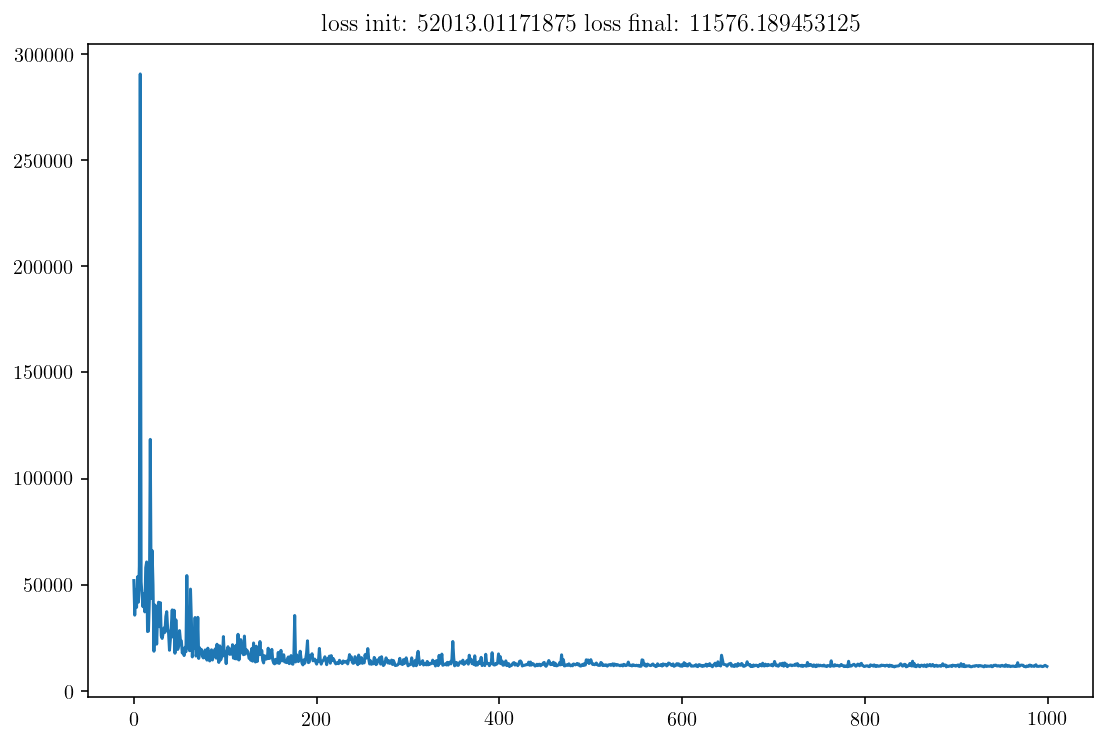

In [133]:
pyro.clear_param_store()
n_steps = 1000
losses = []
for s in range(n_steps):
    losses.append(svi.step(data))
plt.plot(losses)
plt.title(f"loss init: {losses[0]}   loss final: {losses[-1]}")
plt.show()

In [190]:
learned_means = pyro.param('m_loc').detach().numpy()
learned_probs = pyro.param('phi').detach().numpy()
learned_scales = pyro.param('m_scale').detach().numpy()

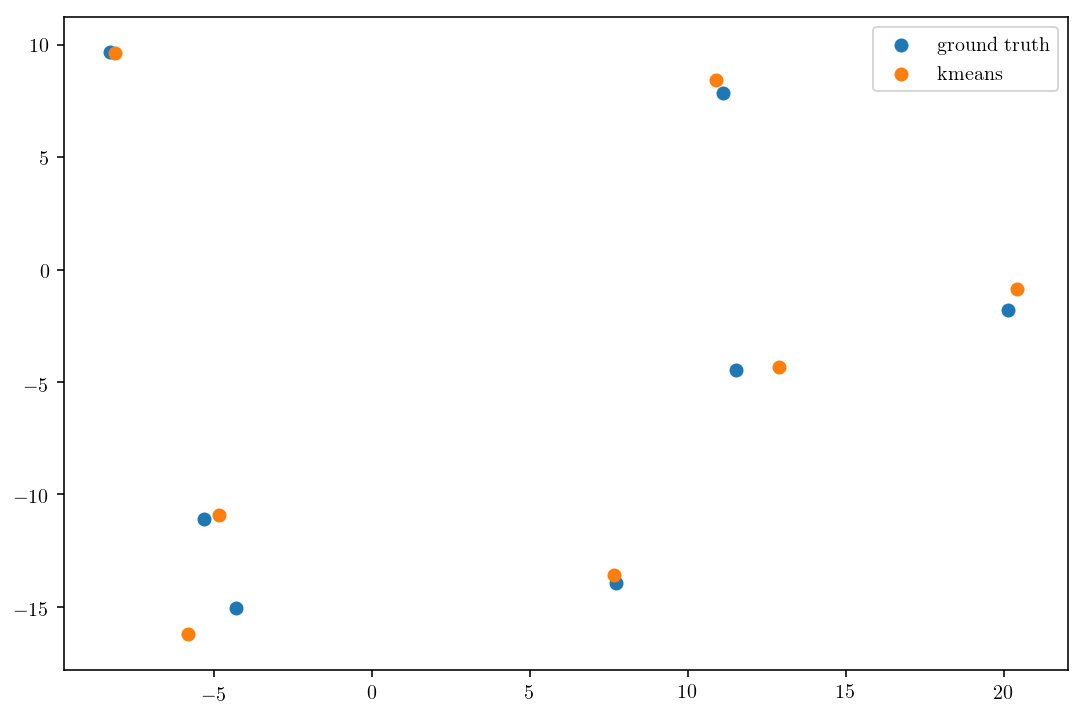

In [135]:
#plt.scatter(learned_means[:,0],learned_means[:,1],label='learned')
plt.scatter(true_means[:,0].numpy(),true_means[:,1].numpy(),label='ground truth')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],label='kmeans')
plt.legend()
plt.show()

In [137]:
from pyro.infer.mcmc import NUTS, MCMC

In [141]:
pyro.clear_param_store()
nuts_kernel = NUTS(model, adapt_step_size=True,jit_compile=True)
hmc_posterior = MCMC(nuts_kernel,200)

In [142]:
hmc_posterior.run(data)

Warmup:  25%|██▍       | 99/400 [00:43<02:11,  2.28it/s, step size=3.38e-63, acc. rate=0.010]


KeyboardInterrupt: 

In [ ]:
'''
Ian's GMM code for comparison
I am trying to switch the generating distribution for the scales to be something with positive support (Gamma)

'''

C = 5
D = d
def model_ihi(data_len,p=False):
    with pyro.plate('class'):
        mu = pyro.sample('mu',dist.MultivariateNormal(torch.zeros([C,D]),torch.diag_embed(torch.ones([C,D])*50)))
        scales = pyro.sample('scales',dist.MultivariateNormal(torch.ones([C,D])*4.05,torch.diag(torch.ones(D)/1.)))
    weights = torch.ones([data_len,C])/C # prior of equal class probabilities
    with pyro.plate('data',data_len) as ind:
        assignment = pyro.sample('assignment',dist.Categorical(weights[ind]))
        obs = pyro.sample('obs',dist.MultivariateNormal(mu[assignment],torch.diag_embed(scales[assignment])))
    return obs, assignment

def guide_ihi(data_len,p=False):
    mu_loc   = pyro.param('mu_loc', torch.zeros([C,D]))
    mu_tril= pyro.param("mu_tril", torch.diag_embed(torch.randn([C,D]).abs()), constraint = constraints.lower_cholesky)


     #scales variational params
    scales_loc = pyro.param("scales_loc",torch.ones([C,D])*10)
    scales_tril= pyro.param("scales_tril", torch.diag_embed(torch.randn([C,D]).abs()), constraint = constraints.lower_cholesky)


    with pyro.plate('class'):
        mu = pyro.sample('mu',dist.MultivariateNormal(mu_loc,scale_tril=mu_tril))
        scales = pyro.sample('scales',dist.MultivariateNormal(scales_loc,scale_tril=scales_tril))
    if p:
        print(mu)
    w = pyro.param('weights',torch.ones([data_len,C])/C,constraint=constraints.simplex)
#     print(w)
    with pyro.plate('data',data_len) as ind:
#         print(ind)
        assignment = pyro.sample('assignment',dist.Categorical(w[ind]),infer={"enumerate": "parallel"})

In [ ]:
pyro.clear_param_store()
model_ihi(train_data.shape[0])
guide_ihi(train_data.shape[0])

In [ ]:
#         var_gamma = dist.Gamma(var_conc,var_rate).to_event(1)
#         print(var_gamma.event_dims)
#         var = pyro.sample('var',var_gamma).diag_embed()
#         corr = pyro.sample('corr', dist.Delta(scales).to_event(1))
        
#         gamma = dist.Gamma(s_shape, s_rate).to_event(1)
#         scales = pyro.sample('scales',gamma)


In [29]:
from matplotlib.patches import Ellipse

In [95]:
Sigma = torch.tensor([[2,1.1],[1.1,3]])
mu = true_means[1]
mvn = torch.distributions.MultivariateNormal(loc=mu,covariance_matrix=Sigma)
samples = mvn.sample(torch.Size([500])).numpy()

In [96]:
evals,evecs = Sigma.symeig(eigenvectors=True)

In [98]:
v = evecs[:,evals.argmax()]
a = np.arctan2(v[1],v[0])*(180/np.pi)

In [105]:
d = 2*torch.sqrt(5.991*evals)

In [106]:
cr = Ellipse(mu, d[1], d[0], angle=a, fill=False)

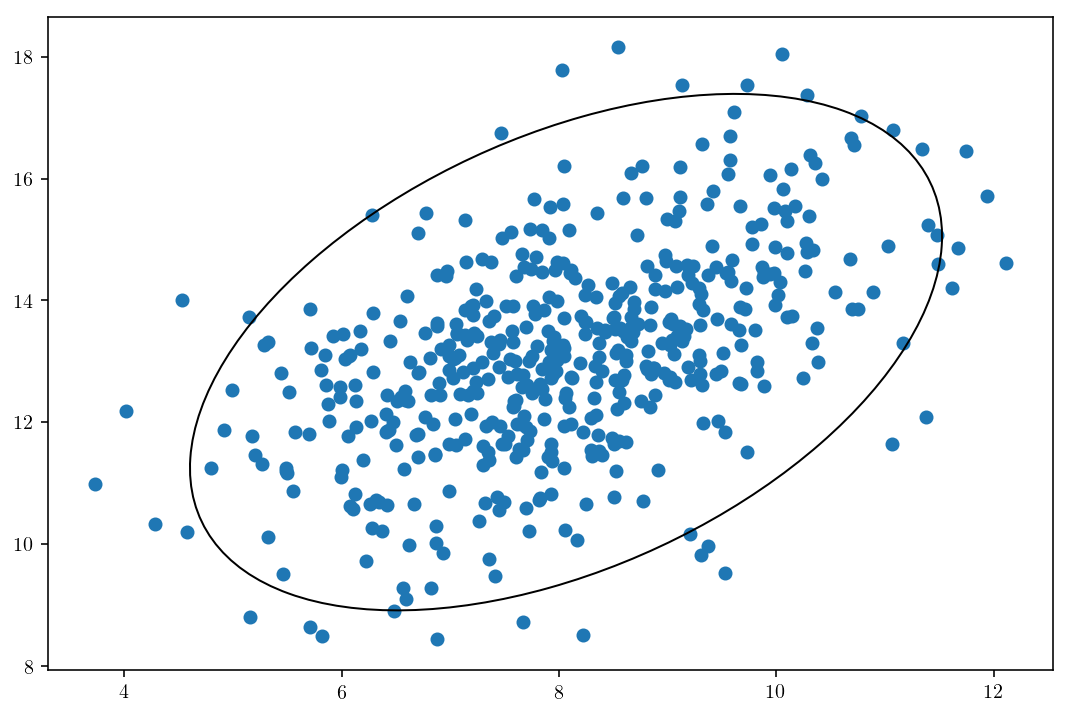

In [107]:
fig, ax = plt.subplots()
ax.scatter(samples[:,0],samples[:,1])
ax.add_patch(cr)
plt.show()

In [ ]:
torch.symeig()

In [ ]:
#Used to make nice plots of the simulated data but i changed the data generation procedure.
if dims>2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(N_classes):
        ax.scatter(data[i,:,0], data[i,:,1], data[i,:, 2])
        ax.scatter(true_means[i,0],true_means[i,1],true_means[i,2],marker="*",s=50)
    ax.set_xlabel(r"x")
    ax.set_ylabel(r"y")
    ax.set_zlabel(r"z")
    ax.view_init(30, 50)
    plt.show()

r = ['x','x','z']
d1,d2 = 0,1
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(N_classes):
    ax.scatter(data[i,:,d1], data[i,:,d2])
    ax.scatter(true_means[i,d1], true_means[i,d2],marker="*",s=50)
ax.set_xlabel(r"{}".format(r[d1]))
ax.set_ylabel(r"{}".format(r[d2]))
#ax.set_zlabel(r"z")
#plt.title(r"True means",fontsize=16)
plt.show()